In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter


# Set seaborn styles for the plots
sns.set_style('whitegrid')
sns.set_context("paper")

In [2]:
# Read data from pickle file
dfx = pd.read_pickle('./data/sym_asy_indices.pkl', compression = 'gzip')

# Extract dates with ASY-H index values above or equal to the low threshold
dates_sym = dfx['SYM_H'].reset_index().copy()
dates_sym = dates_sym.loc[dates_sym['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW]

# Set the last valid year for storm classification
last_valid_year = 2022

# Initialize empty list to store storm data
storms_sym = []

In [3]:
# Iterate over dates with SYM-H index values below the low intensity threshold
for i in range(len(dates_sym)):
    st = dates_sym.iloc[i]['datetime'] - utils.MINIMUM_DAYS_BEFORE
    nd = dates_sym.iloc[i]['datetime'] + utils.MINIMUM_DAYS_AFTER    
    
    # Find the last and first values over the low threshold within a minimum offset of one day before and after
    last_low_value = dfx[st:nd].loc[dfx[st:nd]['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW].last_valid_index()
    first_low_value = dfx[st:nd].loc[dfx[st:nd]['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW].first_valid_index()
    
    # Adjust the start and end dates of the storm period determined with the superposed epoch analysis
    newst = first_low_value - utils.STORM_DAYS_BEFORE_OFFSET
    newst = newst.floor('D')
    newnd = last_low_value + utils.STORM_DAYS_AFTER_OFFSET
    newnd = newnd.ceil('D')
    
    # If the end year exceeds the last valid year, continue to the next date
    if (newnd.year > last_valid_year):
        continue
    
    # Create a new DataFrame to store the storm data within the adjusted storm period
    new_df = dfx[newst:newnd].copy()
    
    # Extend the storm period if there are additional last low values beyond the initial range
    while dfx[newst:newnd].loc[dfx[newst:newnd]['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW].last_valid_index() > last_low_value:
        last_low_value = dfx[newst:newnd].loc[dfx[newst:newnd]['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW].last_valid_index()
        newnd = last_low_value + utils.STORM_DAYS_AFTER_OFFSET
        newnd = newnd.ceil('D')
        new_df = dfx[newst : newnd].copy()    
        
    # Check if there is already a storm in the list and its end date is greater than or equal to the adjusted start date
    if (len(storms_sym) >= 1):
        if storms_sym[-1].index[-1] >= newst:
            # Concatenate the new storm data with the previous storm data
            new_df = pd.concat([storms_sym[-1], new_df])            
            new_df = new_df[~new_df.index.duplicated(keep='first')]            
            storms_sym[-1] = new_df
            continue
    
    # Append the new storm data to the list
    storms_sym.append(new_df)
    
# Print the total number of storms
print(f"Total storms: {len(storms_sym)}")

Total storms: 275


In [4]:
# Create a summary dataframe with the start and end dates, the duration, the minimum SYM-H value 
# of the storm and the corresponding class of the storm
summary_df_sym = utils.get_summary_df_sym(storms_sym)
summary_df_sym['classification'] = 'LOW'
summary_df_sym.loc[(summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_MODERATE) & (summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_INTENSE), 'classification'] = 'MODERATE'
summary_df_sym.loc[(summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_INTENSE) & (summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_SUPERINTENSE), 'classification'] = 'INTENSE'
summary_df_sym.loc[summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_SUPERINTENSE, 'classification'] = 'SUPERINTENSE'

In [5]:
# Get the indices of storms classified as 'LOW'
low_indices = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_LOW ) & 
                                ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_MODERATE ))].index

# Get the indices of storms classified as 'MODERATE'
moderate_indices = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_MODERATE ) & 
                                ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_INTENSE ))].index

# Get the indices of storms classified as 'INTENSE'
intense_indices  = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_INTENSE ) & 
                                ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_SUPERINTENSE ))].index

# Get the indices of storms classified as 'SUPERINTENSE'
superintense_indices  = summary_df_sym.loc[summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_SUPERINTENSE].index


print('low_indices',  len(low_indices))
print('moderate_indices', len(moderate_indices))
print('intense_indices',  len(intense_indices))
print('superintense_indices',  len(superintense_indices))

low_indices 150
moderate_indices 85
intense_indices 23
superintense_indices 7


7 superintense storms
Plotting storm 14
Start date        1982-07-11 00:00:00
End date          1982-07-29 00:00:00
TD                   18 days 00:00:00
Min SYM-H                        -420
classification           SUPERINTENSE
Name: 14, dtype: object
Minimum SYM-H value -420 at: 1982-07-14 01:05:00


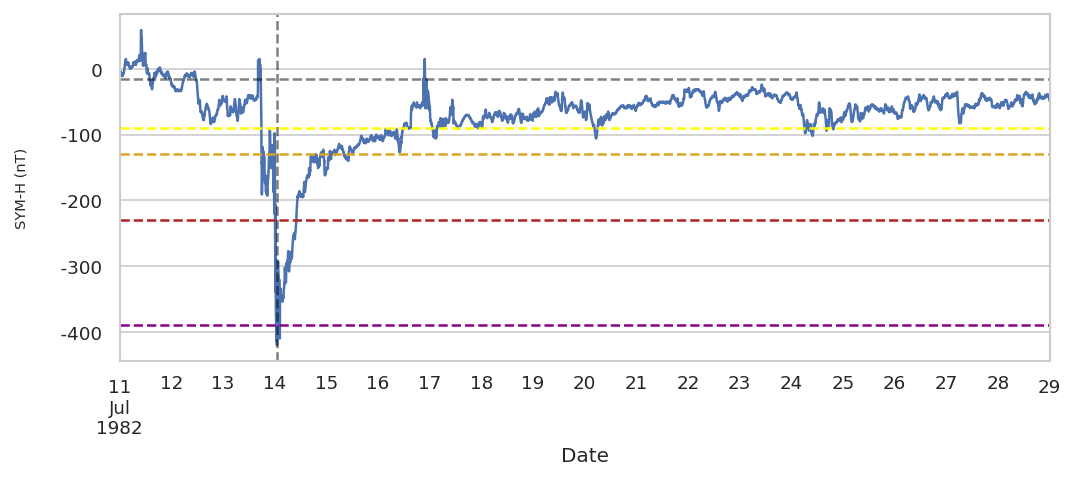

Plotting storm 66
Start date        1989-03-11 00:00:00
End date          1989-03-21 00:00:00
TD                   10 days 00:00:00
Min SYM-H                        -714
classification           SUPERINTENSE
Name: 66, dtype: object
Minimum SYM-H value -714 at: 1989-03-14 00:45:00


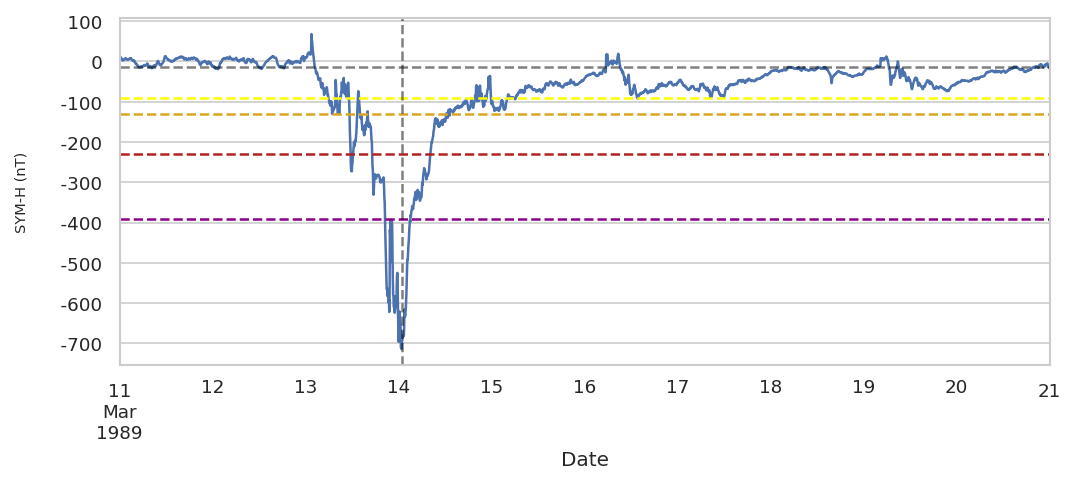

Plotting storm 99
Start date        1991-10-19 00:00:00
End date          1991-11-15 00:00:00
TD                   27 days 00:00:00
Min SYM-H                        -399
classification           SUPERINTENSE
Name: 99, dtype: object
Minimum SYM-H value -399 at: 1991-11-09 01:30:00


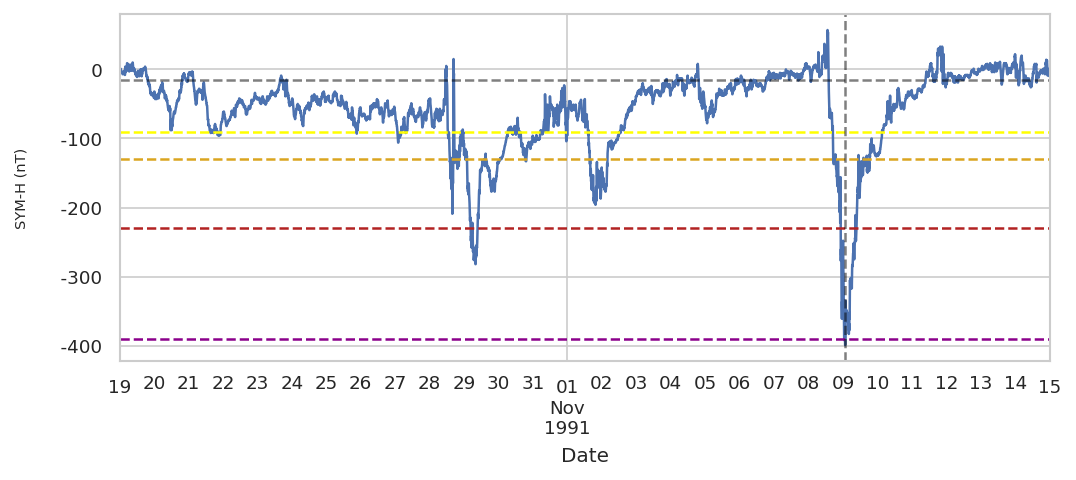

Plotting storm 184
Start date        2001-03-29 00:00:00
End date          2001-04-07 00:00:00
TD                    9 days 00:00:00
Min SYM-H                        -434
classification           SUPERINTENSE
Name: 184, dtype: object
Minimum SYM-H value -434 at: 2001-03-31 08:10:00


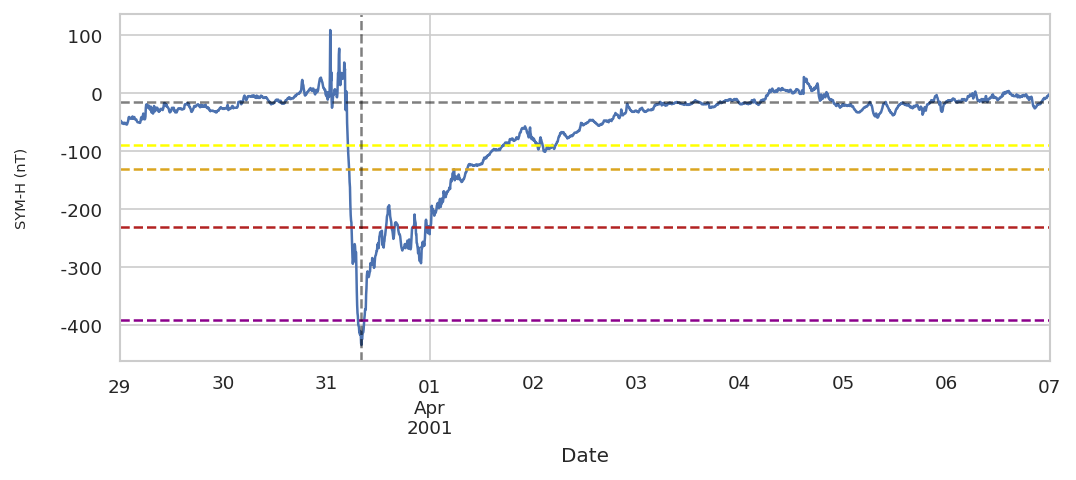

Plotting storm 210
Start date        2003-10-27 00:00:00
End date          2003-11-05 00:00:00
TD                    9 days 00:00:00
Min SYM-H                        -427
classification           SUPERINTENSE
Name: 210, dtype: object
Minimum SYM-H value -427 at: 2003-10-30 22:55:00


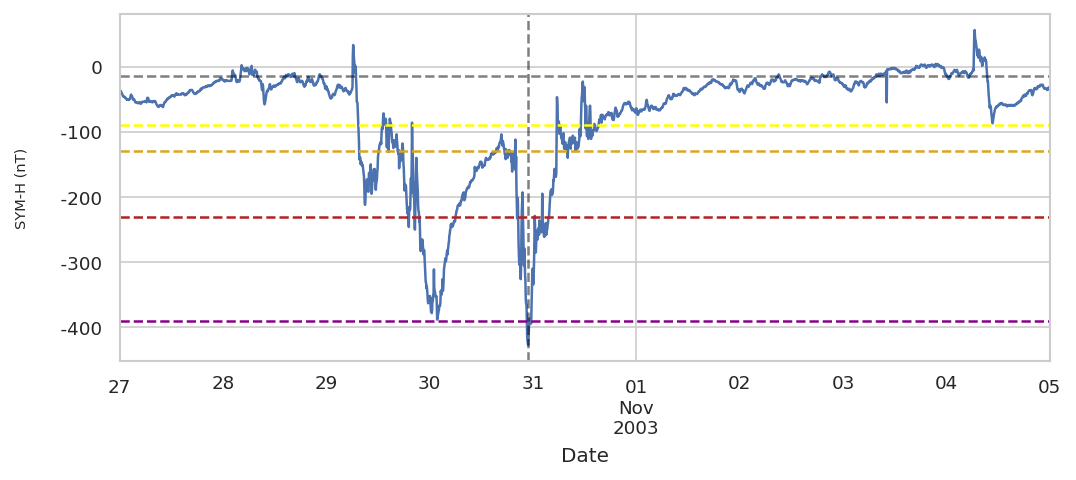

Plotting storm 211
Start date        2003-11-18 00:00:00
End date          2003-11-27 00:00:00
TD                    9 days 00:00:00
Min SYM-H                        -488
classification           SUPERINTENSE
Name: 211, dtype: object
Minimum SYM-H value -488 at: 2003-11-20 18:15:00


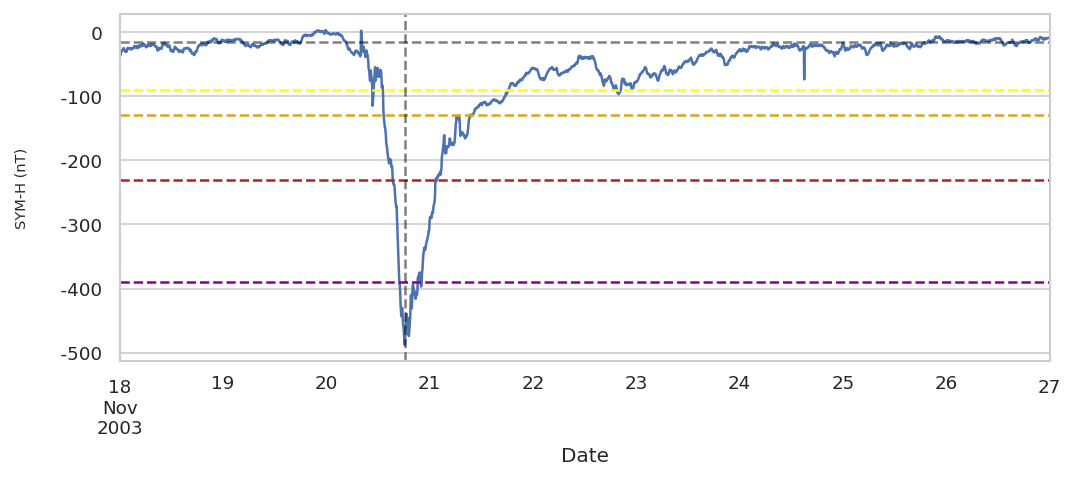

Plotting storm 218
Start date        2004-11-05 00:00:00
End date          2004-11-17 00:00:00
TD                   12 days 00:00:00
Min SYM-H                        -393
classification           SUPERINTENSE
Name: 218, dtype: object
Minimum SYM-H value -393 at: 2004-11-08 05:55:00


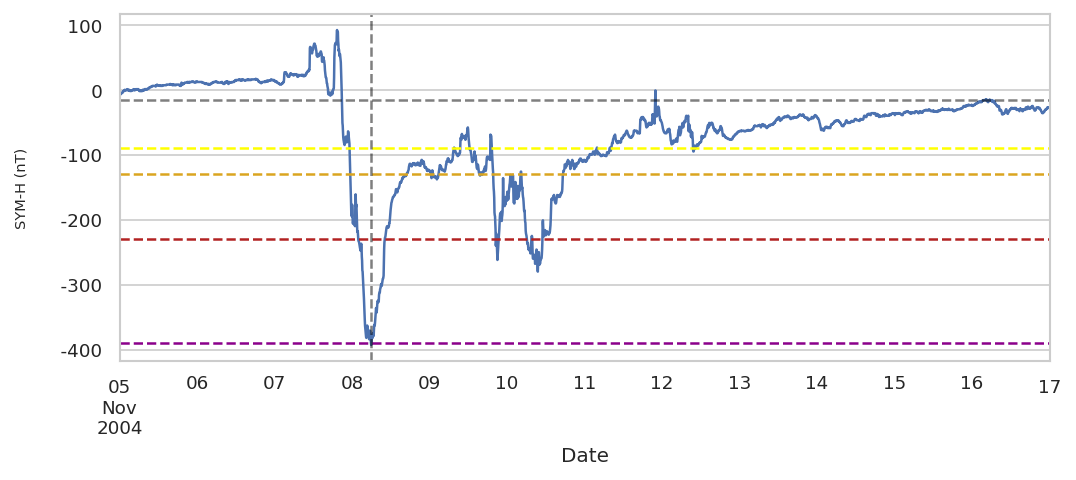

In [6]:
# Plot the super-intense storms
# the yellow horizontal line corresponds to the low intensity threshold
# the orange horizontal line corresponds to the moderate intensity threshold
# the red horizontal line corresponds to the intense threshold
# the magenta horizontal line corresponds to the super-intense threshold
print(f'{len(superintense_indices)} superintense storms')
for ix, ind in enumerate(superintense_indices):
    ax = utils.plot_storm_sym(dfx, summary_df_sym, ind)
    strm = utils.get_storm(dfx, summary_df_sym, ind)
    ax.axvline(strm['SYM_H'].idxmin(), linestyle = '--', color = 'black', alpha = 0.5)
    ax.axhline(-15, linestyle = '--', color = 'black', alpha = 0.5)
    print(f'Minimum SYM-H value {strm["SYM_H"].min()} at: {strm["SYM_H"].idxmin()}')
    plt.show();

Minimum SYM-H value -179 at: 1990-03-12 23:55:00


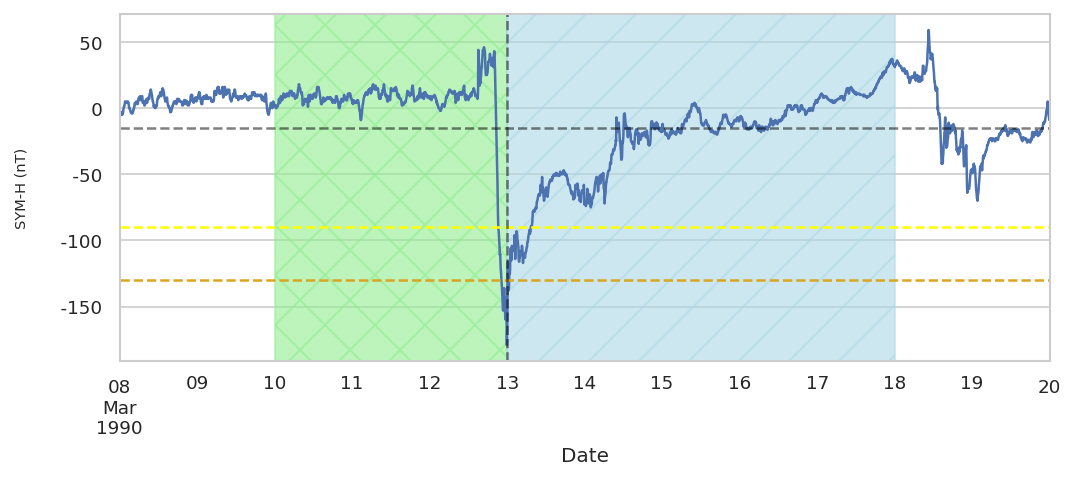

Minimum SYM-H value -309 at: 1990-04-10 16:35:00


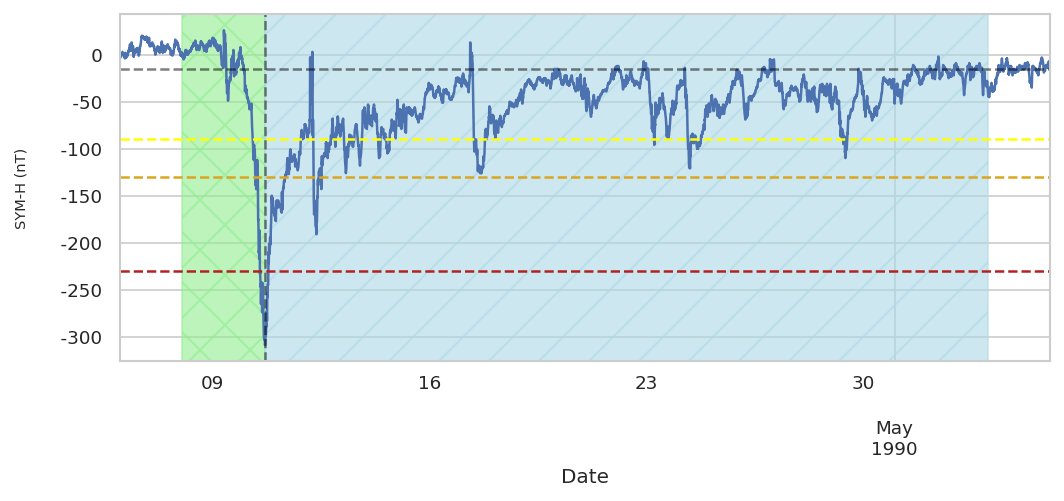

Minimum SYM-H value -288 at: 1989-09-19 05:20:00


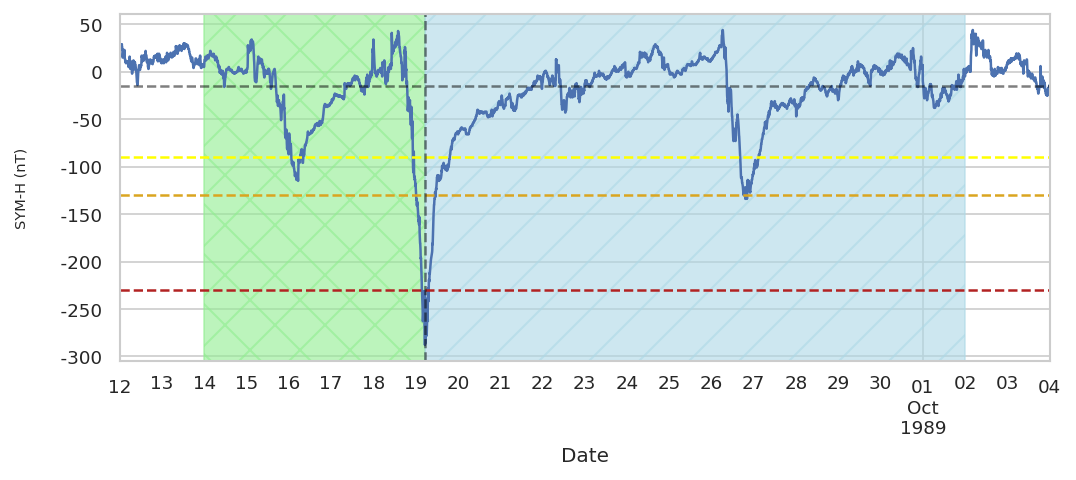

Minimum SYM-H value -399 at: 1991-11-09 01:30:00


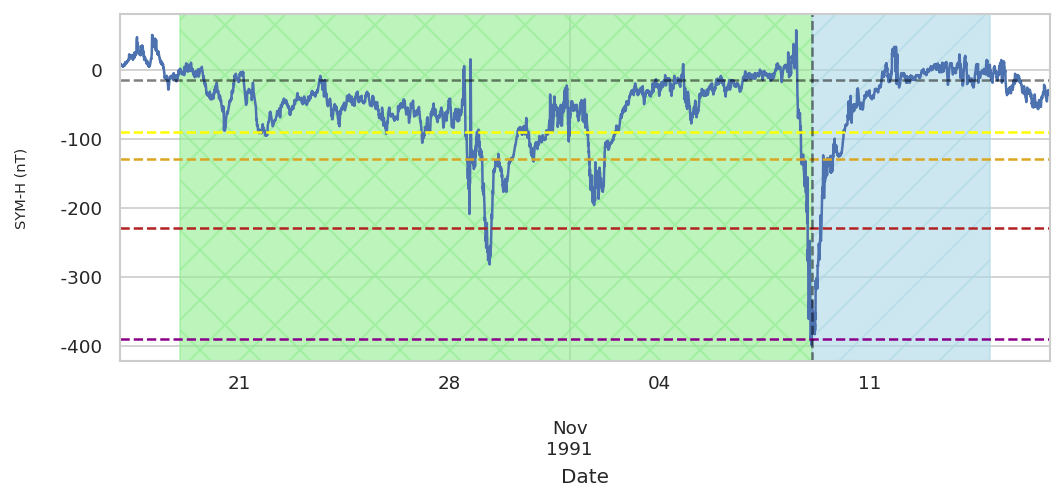

Minimum SYM-H value -427 at: 2003-10-30 22:55:00


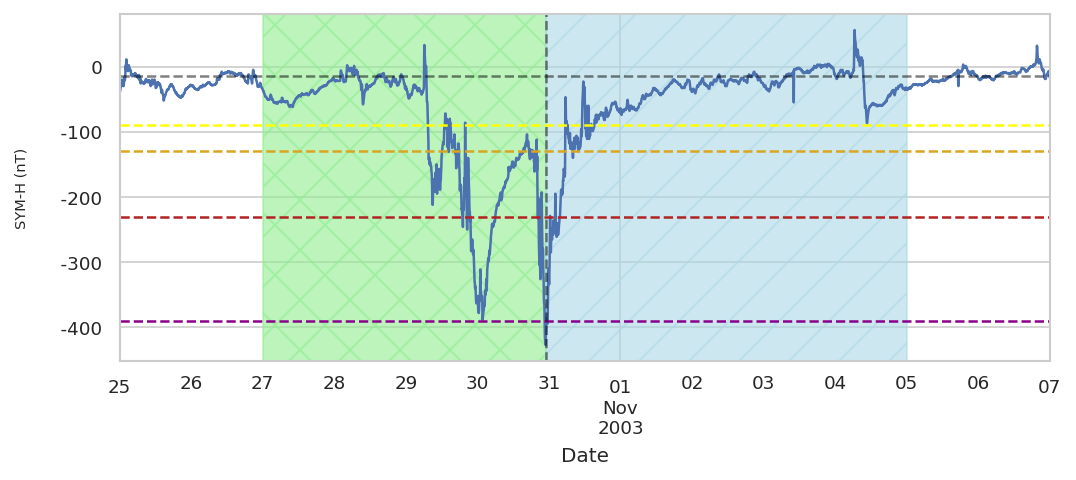

Minimum SYM-H value -393 at: 2004-11-08 05:55:00


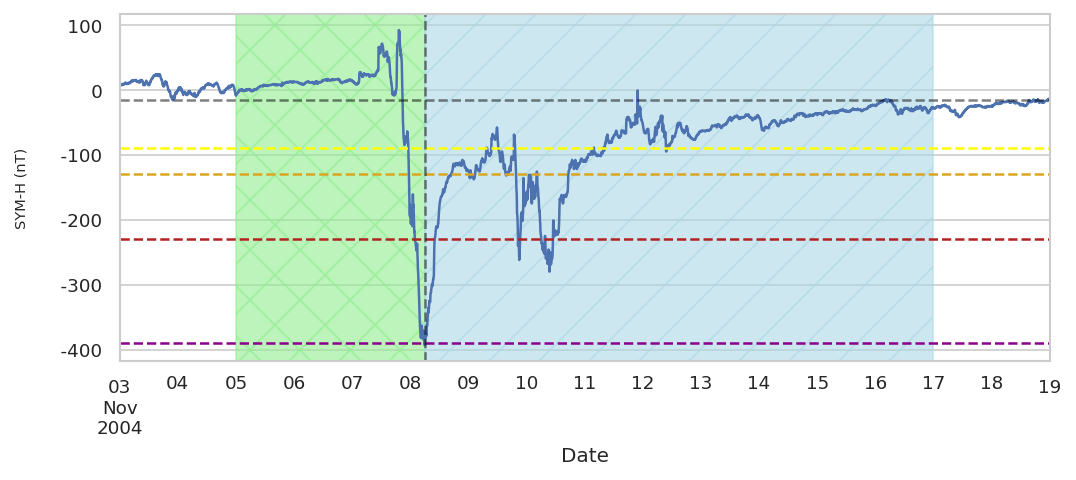

In [12]:
inds = [80, 82, 74, 99, 210, 218]

for ind in inds:
    #ax = utils.plot_storm_sym(dfx, summary_df_sym, ind)
    strm = utils.get_storm(dfx, summary_df_sym, ind)
    strm_start = strm.index[0]
    strm_end = strm.index[-1]
    idxmin = strm['SYM_H'].idxmin()

    offset = pd.DateOffset(days = 2)

    strm_full = dfx[strm_start - offset : strm_end + offset]

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 3))

    # Plot the SYM-H values for the specified storm period
    strm_full["SYM_H"].plot(legend=False, xlabel="Date", ax=ax)

    # Set the y-axis label
    ax.set_ylabel("SYM-H (nT)", fontsize=7)

    # Add horizontal lines to represent different SYM-H thresholds for storm intensity levels
    min_sym = strm_full["SYM_H"].min()
    if min_sym <= utils.SYM_H_THRESHOLD_LOW:
        ax.axhline(utils.SYM_H_THRESHOLD_LOW, linestyle="--", color=utils.COLOR_LOW)

        if min_sym <= utils.SYM_H_THRESHOLD_MODERATE:
            ax.axhline(utils.SYM_H_THRESHOLD_MODERATE, linestyle="--", color=utils.COLOR_MODERATE)

            if min_sym <= utils.SYM_H_THRESHOLD_INTENSE:
                ax.axhline(utils.SYM_H_THRESHOLD_INTENSE, linestyle="--", color=utils.COLOR_INTENSE)

                if min_sym <= utils.SYM_H_THRESHOLD_SUPERINTENSE:
                    ax.axhline(
                        utils.SYM_H_THRESHOLD_SUPERINTENSE, linestyle="--", color=utils.COLOR_SUPERINTENSE
                    )

    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:>8.0f}"))

    #ax.fill_between(strm.index, strm_full['SYM_H'].max(), strm_full['SYM_H'].min(),
    #                interpolate=True, color=utils.COLOR_SUPERINTENSE, alpha = 0.6, hatch='x')

    ax.axvspan(strm.index[0], idxmin, color = 'lightgreen', alpha = 0.6, hatch='x')
    ax.axvspan(idxmin, strm.index[-1], color = 'lightblue', alpha = 0.6, hatch='/')


    ax.axvline(strm['SYM_H'].idxmin(), linestyle = '--', color = 'black', alpha = 0.5)
    ax.axhline(-15, linestyle = '--', color = 'black', alpha = 0.5)
    print(f'Minimum SYM-H value {strm_full["SYM_H"].min()} at: {strm_full["SYM_H"].idxmin()}')
    plt.savefig(f'figs/sym-storm-{ind}.png')
    plt.show();

218